# FilterVariables.ipyn

#### A code to plot variability parameters for all sources in a given dataset and to select the candidate variables using input sigma thresholds.

#### Import all the dependencies and generic setup

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
import tkp.db
import logging
logging.basicConfig(level=logging.INFO)
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING
import sys
sys.path.append('../')
from dblogin import * # This file contains all the variables required to connect to the database
from database_tools import dbtools
from tools import tools
from plotting import plot_varib_params as pltvp
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import random
from matplotlib.colors import LogNorm
import seaborn as sns

#### The input database, dataset and thresholds

In [2]:
dataset_id = 688
database = 'AR_R4'
sigma1 = 2.92542542543 # Threshold on the reduced weighted chi^2
sigma2 = 1.4049049049 # Threshold on the variability parameter
websiteURL = 'http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'

#path='ml_csv_files/'
#stableData = path+'stable_sources.csv'


#### Connect to the database and run the queries

In [3]:
session = dbtools.access(engine,host,port,user,password,database)
VarParams = dbtools.GetVarParams(session,dataset_id)

INFO:tkp.db.database:Database config: postgresql://antoniar@vlo.science.uva.nl:5432/AR_R4
/home/antoniar/TraP_ML_tools_env/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:connected to: postgresql://antoniar@vlo.science.uva.nl:5432/AR_R4


connected!


#### Contents of VarParams

The VarParams array contains all the information for the unique running catalogue sources for the required dataset. Each running catalogue source has a row in this array.


Runningcatalog table contains the parameters (see http://tkp.readthedocs.io/en/r3.0/devref/database/schema.html#runningcatalog), but especially:
 * id
 * dataset_id
 * wm_ra (in degrees)
 * wm_decl (in degrees)
 * avg_ra_err (in degrees)
 * avg_decl_err (in degrees)


Varmetric table contains (see http://tkp.readthedocs.io/en/r3.0/devref/database/schema.html#varmetric), but especially:
 * Varmetric.runcat (link to Runningcatalog table)
 * v_int (the variability parameter for the last datapoint in the lightcurve)
 * eta_int (the reduced weighted chi^2 for the last datapoint in the lightcurve)
 * band (a link back to Frequencyband table)
 * newsource  (a link back to newsource table)
 * sigma_rms_max (SNR max for new sources)
 * sigma_rms_min (SNR min for new sources)
 * lightcurve_max (maximum flux in the lightcurve)
 * lightcurve_avg (mean flux in the lightcurve)
 * lightcurve_median (median flux in the lightcurve)

#### Example queries:

In [4]:
#print VarParams[1].Varmetric.runcat.dataset_id
#print VarParams[1].Runningcatalog.id
#print [VarParams[i].Runningcatalog.id for i in range(len(VarParams))]

#### Set up data for plotting

Obtain data to plot the variability paramters against the reduced weighted chi^2. All sources with fewer than 1 datapoints are excluded. Columns are [runcat_id, eta_nu, V_nu, lightcurve_max, lightcurve_median, nu, number of datapoints, new source id].

In [5]:
plotdata = [[VarParams[i].Runningcatalog.id, VarParams[i].Varmetric.eta_int, VarParams[i].Varmetric.v_int, VarParams[i].Varmetric.lightcurve_max, VarParams[i].Varmetric.lightcurve_median, (VarParams[i].Varmetric.band.freq_central/1e6), VarParams[i].Runningcatalog.datapoints, VarParams[i].Varmetric.newsource] for i in range(len(VarParams))]
plotdata = pd.DataFrame(data=plotdata,columns=['runcat','eta','V','maxFlx','avgFlx','freq','dpts','newSrc'])
plotdata = plotdata.fillna('N')

#plotdata = pd.read_csv(stableData)
#plotdata = pd.DataFrame(data=plotdata,columns=['runcat','eta','V','flux','fluxrat','freq','dpts','newSrc','ttype'])

#### Gaussian fitting to population variability parameters

Obtaining the Gaussian fit parameters in log space for the reduced weighted Chi^2 and the variability parameter. The first parameters assume a median clipped distribution (all values 4 sigma away from median are clipped) whereas the other simply fits the data.

In [6]:
plotdata = plotdata.loc[(plotdata['eta'] > 0) & (plotdata['V'] > 0) & (plotdata['newSrc']=='N')]
#plotdata = plotdata.loc[(plotdata['eta'] > 0) & (plotdata['V'] > 0) & (plotdata['ttype']==2)]
paramx, paramx2 = tools.SigmaFit(np.log10(plotdata['eta']))
paramy, paramy2 = tools.SigmaFit(np.log10(plotdata['V']))

In [7]:
if sigma1 == 0:
    sigcutx = 0
else:
    sigcutx = paramx[1]*sigma1+paramx[0]

if sigma2 == 0:
    sigcuty = 0
else:
    sigcuty = paramy[1]*sigma2+paramy[0]

print('Gaussian Fit eta: '+str(round(10.**paramx[0],2))+'(+'+str(round((10.**(paramx[0]+paramx[1])-10.**paramx[0]),2))+' '+str(round((10.**(paramx[0]-paramx[1])-10.**paramx[0]),2))+')')
print('Gaussian Fit V: '+str(round(10.**paramy[0],2))+'(+'+str(round((10.**(paramy[0]+paramy[1])-10.**paramy[0]),2))+' '+str(round((10.**(paramy[0]-paramy[1])-10.**paramy[0]),2))+')')
print 'Eta_nu threshold='+str(10.**sigcutx)+', V_nu threshold='+str(10.**sigcuty)

Gaussian Fit eta: 0.25(+0.72 -0.19)
Gaussian Fit V: 0.06(+0.07 -0.03)
Eta_nu threshold=12.7339240063, V_nu threshold=0.177391789696


#### Find the unique frequencies for plotting

In [8]:
frequencies = plotdata.freq.unique()
print frequencies

[ 155.95550537  123.92425537  184.86175537  148.92425537]


#### Create a colourmap for each of the parameters

In [9]:
col = pltvp.make_cmap(frequencies)
random.shuffle(col)

In [10]:
def newCmap(colour):
    n,r,g,b = colour
    cdict = {'red':((0,1,1),(1,r,r)),
            'green':((0,1,1),(1,g,g)),
            'blue':((0,1,1),(1,b,b))}
    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

#### Creating eta V plot

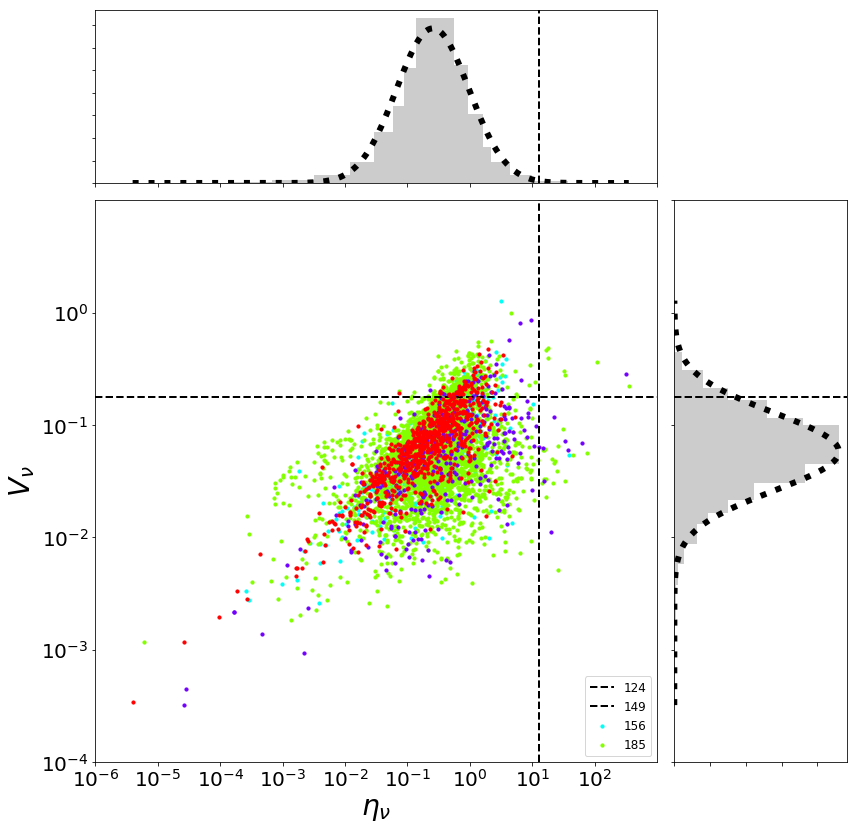

In [11]:
nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(12,12))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

axHistx.hist(x, bins=pltvp.make_bins(x), normed=1, histtype='stepfilled', color='k',alpha=0.2)
axHisty.hist(y, bins=pltvp.make_bins(y), normed=1, histtype='stepfilled', orientation='horizontal', color='k', alpha=0.2)

freq_labels=[int(f+0.5) for f in frequencies]
axScatter.legend(np.sort(freq_labels,axis=0),loc=4, prop=fontP)
xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['freq']==frequencies[i])]
    xdata_var=np.log10(plotdataTMP['eta'])
    ydata_var=np.log10(plotdataTMP['V'])
    axScatter.scatter(xdata_var, ydata_var,color=col[i], s=10., zorder=i)
    #sns.kdeplot(np.log10(plotdataTMP.eta), np.log10(plotdataTMP.V), n_levels=5, zorder=i, shade_lowest=False, shade=False, color=col[i], ax=axScatter, alpha=0.6)

if sigcutx != 0 or sigcuty != 0:
    axHistx.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
    axHisty.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    axScatter.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    axScatter.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
    
axScatter.legend(np.sort(freq_labels,axis=0), loc=4, prop=fontP)

    
range_x,fitx = pltvp.gaussian_fit(x,paramx)
axHistx.plot(range_x,fitx, 'k:', linewidth=6)
range_y,fity = pltvp.gaussian_fit(y,paramy)
axHisty.plot(fity,range_y, 'k:', linewidth=6)


Black dashed lines represent the sigma thresholds imposed on the data.
Black dotted lines show the histogram fit used to calculate the sigma thresholds

#### Create diagnostic plots 
eta and V versus the average flux and ratio of max flux and average flux

KeyError: 'flux'

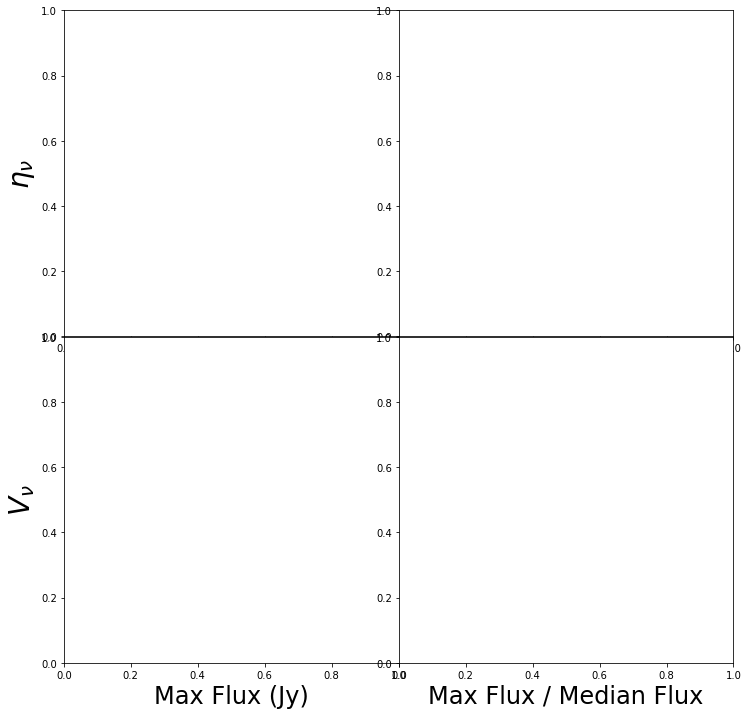

In [12]:
fig = plt.figure(1,figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fontP = FontProperties()
fontP.set_size('large')
fig.subplots_adjust(hspace = .001, wspace = 0.001)
ax1.set_ylabel(r'$\eta_\nu$', fontsize=28)
ax3.set_ylabel(r'$V_\nu$', fontsize=28)
ax3.set_xlabel('Max Flux (Jy)', fontsize=24)
ax4.set_xlabel('Max Flux / Median Flux', fontsize=24)

for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['freq']==frequencies[i])]
    #xdata_ax3=np.log10(plotdataTMP['maxFlx'])
    xdata_ax3=np.log10(plotdataTMP['flux'])
    #xdata_ax4=plotdataTMP['maxFlx']/plotdataTMP['avgFlx']
    xdata_ax4=plotdataTMP['fluxrat']
    ydata_ax1=np.log10(plotdataTMP['eta'])
    ydata_ax3=np.log10(plotdataTMP['V'])
    ax1.scatter(xdata_ax3, ydata_ax1,color=col[i], s=10., zorder=5)
    ax2.scatter(xdata_ax4, ydata_ax1,color=col[i], s=10., zorder=6)
    ax3.scatter(xdata_ax3, ydata_ax3,color=col[i], s=10., zorder=7)
    ax4.scatter(xdata_ax4, ydata_ax3,color=col[i], s=10., zorder=8)
    
ax4.legend(np.sort(freq_labels,axis=0), loc=4, prop=fontP)

#Xax3=np.log10(plotdata['maxFlx'])
#Xax4=plotdata['maxFlx']/plotdataTMP['avgFlx']
Xax3=np.log10(plotdataTMP['flux'])
Xax4=plotdataTMP['fluxrat']

Yax1=np.log10(plotdata['eta'])
Yax3=np.log10(plotdata['V'])
    
if sigcutx != 0 or sigcuty != 0:
    ax1.axhline(y=sigcutx, linewidth=2, color='k', linestyle='--')
    ax2.axhline(y=sigcutx, linewidth=2, color='k', linestyle='--')
    ax3.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    ax4.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')


xmin_ax3=int(min(Xax3)-1.1)
xmax_ax3=int(max(Xax3)+1.1)
xmin_ax4=0.9
xmax_ax4=int(max(xdata_ax4))+1.5
ymin_ax1=int(min(Yax1)-1.1)
ymax_ax1=int(max(Yax1)+1.1)
ymin_ax3=int(min(Yax3)-1.1)
ymax_ax3=int(max(Yax3)+1.1)

xvals_ax3=range(xmin_ax3,xmax_ax3)
xtxts_ax3=[r'$10^{'+str(a)+'}$' for a in xvals_ax3]
yvals_ax1=range(ymin_ax1,ymax_ax1)
ytxts_ax1=[r'$10^{'+str(a)+'}$' for a in yvals_ax1]
yvals_ax3=range(ymin_ax3,ymax_ax3)
ytxts_ax3=[r'$10^{'+str(a)+'}$' for a in yvals_ax3]

ax3.set_xticks(xvals_ax3)
ax3.set_xticklabels(xtxts_ax3, fontsize=10)
ax1.set_yticks(yvals_ax1)
ax1.set_yticklabels(ytxts_ax1, fontsize=10)
ax3.set_yticks(yvals_ax3)
ax3.set_yticklabels(ytxts_ax3, fontsize=10)


ax1.set_ylim(ymin_ax1,ymax_ax1)
ax3.set_ylim(ymin_ax3,ymax_ax3)
ax3.set_xlim(xmin_ax3,xmax_ax3)
ax4.set_xlim(xmin_ax4,xmax_ax4)

ax1.set_xlim( ax3.get_xlim() )
ax4.set_ylim( ax3.get_ylim() )
ax2.set_xlim( ax4.get_xlim() )
ax2.set_ylim( ax1.get_ylim() )
ax1.xaxis.set_major_formatter(nullfmt)
ax4.yaxis.set_major_formatter(nullfmt)
ax2.xaxis.set_major_formatter(nullfmt)
ax2.yaxis.set_major_formatter(nullfmt)

#### Print out the URL to the Banana webpage for each candidate

In [ ]:
#tmp=[x[0] for x in plotdata if x[1]>10.**sigcutx and x[2]>10.**sigcuty and x[7]==None and x[6]>1]
tmp=plotdata.loc[(plotdata['eta']>=10.**sigcutx) & (plotdata['V']>=10.**sigcuty)]
IdTrans=tmp.runcat.unique()
if len(tmp)>0:
    for a in IdTrans:
        print websiteURL+str(a)
else:
    print "No Variables"
